# MCT4052 Workshop 8b: Tensorflow-Keras ANN Regressor

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

This notebook shows how to train, test and use an ANN for regression in tensorflow. We use the same dataset used in earlier Workshops.

### 1. Importing Tensorflow and Keras


In [1]:
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
#ms.use("seaborn-v0_8")
import IPython.display as Ipd
import os
import sklearn
import scipy
import datetime

%matplotlib inline
%config IPCompleter.greedy=True

# Import TensorFlow and Keras
import tensorflow as tf

# display tensorflow version (this notwbook was developed with 2.7)
print(tf.__version__)

2024-02-29 20:18:26.972295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


### 2. Computing features, targets and splitting the dataset

This time we store the features in an numpy array of matrices (i.e. a 3D array) ad tensorflow is able to "flatten" the data internally (is instructed to do so).

In [2]:
sr = 44100

def lin_interp_2d(data, out_size):
    
    x_in_size = data.shape[1]
    y_in_size = data.shape[0]
    x_in = np.arange(0,x_in_size)
    y_in = np.arange(0,y_in_size)
    interpolator = scipy.interpolate.RegularGridInterpolator((x_in, y_in), data.T, method='linear', bounds_error=False)
    x_out = np.arange(0,x_in_size-1,((x_in_size-1)/out_size[1]))
    y_out = np.arange(0,y_in_size-1,((y_in_size-1)/out_size[0]))
    x_out, y_out = np.meshgrid(x_out, y_out, indexing='ij', sparse=True)
    output = interpolator((x_out, y_out)).T
    output = output[0:out_size[0],0:out_size[1]]

    return output

def extract_features_targets(filename, sr):
    
    signal, dummy = librosa.load(filename, sr=sr, mono=True)
    features = librosa.feature.melspectrogram(y=signal, n_mels=32)
    features = lin_interp_2d(features, (32,16)) # scaling to identical lenght
    
    targets = np.zeros((1,2))
    #centroid and flatness are in very different ranges, they are scaled to be in a similar range (important for the loss)
    targets[0,0] = np.mean(librosa.feature.spectral_centroid(y=signal))
    targets[0,1] = np.mean(librosa.feature.spectral_flatness(y=signal))
    
    return features, targets

filenames = os.listdir('./data/examples2')
features = np.zeros((len(filenames),32,16)) #3D Numpy array to store MFCC computed e changed if using more or less features)
targets = np.zeros((len(filenames),2))

for i in range(len(filenames)):
    features[i,:,:], targets[i,:] = extract_features_targets('./data/examples2/'+filenames[i], sr) # alternative features[i,:,:]

#scaling targets as their range (centroid and flatness) is significantly different
from sklearn.preprocessing import StandardScaler
tar_scaler = StandardScaler()
targets = tar_scaler.fit_transform(targets)

print('Done!')

Done!


In [3]:
# for the splitting we still use scikit learn

from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, tar_train, tar_test = train_test_split(features, targets, test_size=0.2)

### 3. Defining, compiling, training and using the ANN

Compared to the previous notebook, setting an appropriate loss function (related to the error) is a key element to train a regression model

In [4]:
# building the model, the input layer must match the input data
# for regression we need an output for each target value
# here we also integrate a normalization layer (not an absolute must)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 16)),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(2, activation='relu')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 512)               0         
                                                                 
 normalization (Normalizati  (None, 512)               1025      
 on)                                                             
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 6177 (24.13 KB)
Trainable params: 5152 (20.12 KB)
Non-trainable params: 1025 (4.01 KB)
_________________________________________________________________


In [5]:
# setting loss function and metric
# we also specify the learning rate, which needs to be further
# adjusted to speed up the training

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

In [6]:
# fitting the model and setting some parameters

history = model.fit(
    feat_train,
    tar_train,
    batch_size=32,
    epochs=100,
    validation_split = 0.1
)

Epoch 1/100
4/4 [==============================] - 1s 51ms/step - loss: 1.0061 - val_loss: 1.0343
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7846 - val_loss: 0.8795
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7316 - val_loss: 0.8700
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.7218 - val_loss: 0.8753
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.7075 - val_loss: 0.8516
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.6970 - val_loss: 0.8335
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.6826 - val_loss: 0.8184
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6832 - val_loss: 0.8170
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6724 - val_loss: 0.8178
Epoch 10/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6697 - val_loss: 0.8166
Epoch 11/100
4/4 [========

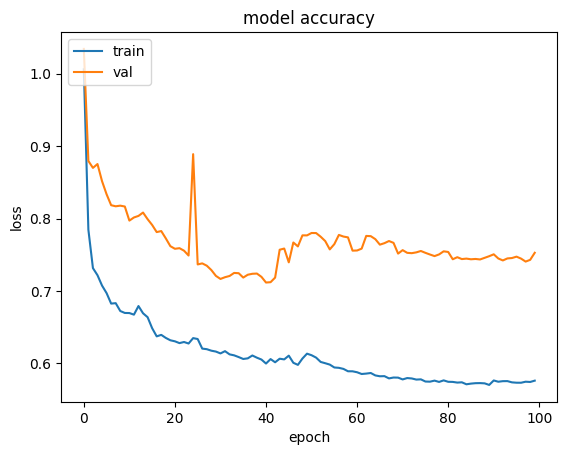

In [7]:
# plotting validation and train loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
# evaluating performance on test set
# tensorflow provides many error-related metrics
# but it does not provide the R2 score (but we can still use scikit learn)

tar_pred = model.predict(feat_test)

print('Coefficient of determination (r2 score): %.4f'% sklearn.metrics.r2_score(tar_test, tar_pred))

2/2 [==============================] - 0s 2ms/step
Coefficient of determination (r2 score): 0.2575


### 4. Follow up activities

1. Try to improve performances.